# Project 2 - PLANT SPECIES RECOGNITION

In [24]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mahotas.features import haralick
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage import feature
%matplotlib inline

Let's start with defining feature vector extracting functions. Following function is extracting contur based features.
[All stats used are presented here.](https://docs.opencv.org/master/d1/d32/tutorial_py_contour_properties.html)

In [25]:
def extract_contour_features(image):
    """
    :param image: grayscale
    :return: feature vector
    """
    # extracting leaf contour
    ret, th = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    contours, hierarchy = cv.findContours(cv.bitwise_not(th), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt = max(contours, key=cv.contourArea)
    x, y, w, h = cv.boundingRect(cnt)
    aspect_ratio = float(w) / h
    area = cv.contourArea(cnt)
    rect_area = w * h
    # ratio of contour area to bounding rectangle area.
    extent = float(area) / rect_area
    hull = cv.convexHull(cnt)
    hull_area = cv.contourArea(hull)
    # ratio of contour area to its convex hull area.
    solidity = float(area) / hull_area
    # diameter of the circle whose area is same as the contour area.
    equi_diameter = np.sqrt(4 * area / np.pi)
    (x, y), (MA, ma), angle = cv.fitEllipse(cnt)
    mask = np.zeros(image.shape, np.uint8)
    cv.drawContours(mask, [cnt], 0, 255, -1)
    # Contour Perimeter
    perimeter = cv.arcLength(cnt, True)
    # average intensity of the object in grayscale
    mean_val = cv.mean(image, mask=mask)
    return np.array([aspect_ratio, extent, solidity, equi_diameter, perimeter, hull_area, mean_val[0]])

Next we define feature vector extracting function based on Haralick feature vector.

In [26]:
def extract_haralick_features(image, mode='default'):
    """
    Function extracting texture features
    https://mahotas.readthedocs.io/en/latest/api.html?highlight=haralick#mahotas.features.haralick
    :param image: grayscale
    :param mode: thresh - threshold is on, default - threshold is off
    :return: feature vector
    """
    if mode == 'thresh':
        # calculate haralick texture features for 4 types of adjacency
        ret, th = cv.threshold(image, 0, 255, cv.THRESH_TOZERO_INV + cv.THRESH_OTSU)
        textures = haralick(th, ignore_zeros=True)
    else:
        textures = haralick(image)
    # take the mean of it and return it
    ht_mean = textures.mean(axis=0)
    return ht_mean

Next we define Local Binary Pattern feature vector extraction.

In [27]:
def extract_lbp_feature(image, num_points=24, radius=8, eps=1e-7):
    """
    :param image: grayscale
    :param num_points: Number of points in a circularly symmetric neighborhood to consider.
    :param radius: The radius of the circle, which allows us to account for different scales.
    :param eps: Number used for normaliztaion
    :return:
    """
    lbp = feature.local_binary_pattern(image, num_points,
                                       radius, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, num_points + 3),
                             range=(0, num_points + 2))

    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    # return the histogram of Local Binary Patterns
    return hist

Next we define KAZE feature vector extraction.

In [28]:
def kaze_features(image, vector_size=32):
    alg = cv.KAZE_create()
    # Finding image keypoints
    kps = alg.detect(image)
    # Getting first 32 of them.
    # Number of keypoints is varies depend on image size and color pallet
    # Sorting them based on keypoint response value(bigger is better)
    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    # computing descriptors vector
    kps, dsc = alg.compute(image, kps)
    dsc = dsc.mean(axis=0)
    return dsc

Finnaly we define our last feature vector - histogram.

In [29]:
def hist_features(image, eps=1e-7):
    hist = cv.calcHist([image], [0], None, [256], [0, 256])
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)

    # return the histogram of Local Binary Patterns
    return hist.flatten()

Lets now load images and process them to grayscale for feature extraction

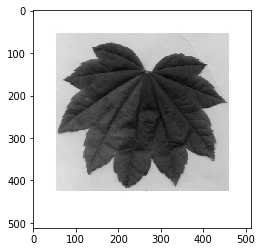

In [30]:
plants = ['circinatum', 'garryana', 'glabrum', 'kelloggii', 'macrophyllum', 'negundo']
paths = []
images = []
train_labels = []
for p in plants:
    paths.append(glob.glob('isolated/' + p + '/*'))

i = 0
for path in paths:
    for file in path:
        image = cv.imread(file)
        # convert the image to grayscale
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        images.append(gray)
        train_labels.append(i)
    i += 1
plt.imshow(images[1],cmap='gray')

Now let's define function for looping through images and applying feature extraction.

In [31]:

def process_data(gray_images, alg):
    fv = []
    for img in gray_images:
        fv.append(alg(img))
    return fv

Next lets select which feature vectors we will test:

In [32]:
features = []
# if you want to test different feature vector uncomment or comment line below 
features.append(process_data(images, extract_contour_features))
features.append(process_data(images, hist_features))
features.append(process_data(images, extract_lbp_feature))
# features.append(process_data(images, kaze_features))
# features.append(process_data(images, extract_haralick_features))

# create one vector
train_features = np.concatenate(features, axis=1)
train_features.shape

(442, 289)

Next lets create classifier, train and evaluate it.

In [34]:
# create the classifier
print("[STATUS] Creating the classifier..")
clf_svm = LinearSVC(max_iter=9000)

# fit the training data and labels
print("[STATUS] Fitting data/label to model..")
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
from sklearn.model_selection import train_test_split, cross_val_score

score = cross_val_score(clf_svm, train_features, train_labels, cv=10, n_jobs=-1)
print('10 fold cross validation scores:')
print(score)
print('Mean: {}'.format(np.mean(score)))
print('Median: {}'.format(np.median(score)))
print('Std: {}'.format(np.std(score)))

xTrain, xTest, yTrain, yTest = train_test_split(train_features, train_labels, test_size=0.2, random_state=0)
# train linear svc
clf_svm.fit(xTrain, yTrain)
# score = clf_svm.score(xTrain, yTrain)
# print('[TRAIN] Accuracy of the model is equal: {}'.format(score))
score = clf_svm.score(xTest, yTest)
print('[TEST] 80/20 Accuracy of the model is equal: {}'.format(score))
from sklearn.metrics import classification_report
test_pred = clf_svm.predict(xTest)
print(classification_report(test_pred, yTest, target_names=plants))

[STATUS] Creating the classifier..
[STATUS] Fitting data/label to model..
10 fold cross validation scores:
[0.95555556 0.97777778 1.         0.97727273 0.97727273 0.97727273
 0.97727273 0.97727273 0.97727273 1.        ]
Mean: 0.9796969696969697
Median: 0.9772727272727273
Std: 0.012025718112987988
[TEST] 80/20 Accuracy of the model is equal: 0.9887640449438202
              precision    recall  f1-score   support

  circinatum       1.00      1.00      1.00        14
    garryana       1.00      1.00      1.00        17
     glabrum       1.00      1.00      1.00        17
   kelloggii       1.00      1.00      1.00        17
macrophyllum       0.94      1.00      0.97        17
     negundo       1.00      0.86      0.92         7

    accuracy                           0.99        89
   macro avg       0.99      0.98      0.98        89
weighted avg       0.99      0.99      0.99        89

